<a target="_blank" href="https://colab.research.google.com/github/ClaudioSalvatoreArcidiacono/felimination/blob/main/docs/tutorials/recursive_feature_elimination.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# Recursive Feature Elimination (RFE)

This tutorial will show an example of how we can use recursive feature elimination to improve our model performances.
More specifically, this tutorial will illustrate how to perform backward recursive feature elimination based on permutation importance using the class [`felimination.rfe.PermutationImportanceRFECV`](https://claudiosalvatorearcidiacono.github.io/felimination/reference/RFE/#felimination.rfe.PermutationImportanceRFECV)

In [ ]:
# Install felimination
! pip install felimination

## Create a dummy Dataset

For this tutorial we will use a dummy classification dataset created using `sklearn.datasets.make_classification`.
For this dataset we will have `6` predictive features, `10` redundant and `184` random features.

In [2]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=1000,
    n_features=200,
    n_informative=6,
    n_redundant=10,
    n_clusters_per_class=1,
    random_state=42,
    shuffle=False
)

## Evaluate performances without feature elimination

In [3]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.linear_model import LogisticRegression


# Define a simple logistic regression model
model = LogisticRegression(random_state=42)

# Perform cross-validation
cv_results = cross_validate(
    model,
    X,
    y,
    cv=StratifiedKFold(random_state=42, shuffle=True),
    scoring="roc_auc",
    return_train_score=True,
)

cv_results["test_score"].mean()

0.8561362716271628

## Perform now feature elimination

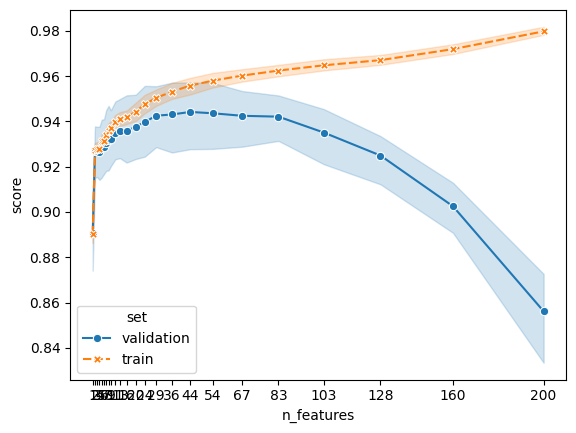

PermutationImportanceRFECV(callbacks=[<function plot_progress_callback at 0x103583d80>],
                           cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                           estimator=LogisticRegression(random_state=42),
                           scoring='roc_auc', step=0.2)

In [4]:
from felimination.rfe import PermutationImportanceRFECV
from felimination.callbacks import plot_progress_callback


selector = PermutationImportanceRFECV(
    model,
    step=0.2,
    callbacks=[plot_progress_callback],
    scoring="roc_auc",
    cv=StratifiedKFold(random_state=42, shuffle=True),
)
selector.fit(X, y)

Notice how model performances increase with the progressive elimination of features.

This is due to the fact that models with a lot of not predictive feature tend to find patterns even in random noise and end up overfitting, see how the train score and the validation score get closer with the progressive elimination of features.

In [5]:
import pandas as pd

cv_results_df = pd.DataFrame(selector.cv_results_)

cv_results_df[["mean_test_score", "n_features"]].sort_values(
    "mean_test_score", ascending=False
).head(10)

,mean_test_score,n_features
7,0.944138,44
6,0.943558,54
8,0.943018,36
9,0.942478,29
5,0.942438,67
4,0.942058,83
10,0.939718,24
11,0.937578,20
12,0.935838,16
13,0.935698,13


The best AUC score obtained with feature elimination is now 0.94, that's 0.08 AUC points obtained from less features.

If I had to choose a number of features, I would probably go for 13 number of features because there the validation score is very close to the train score.

We can do this using the method `set_n_features_to_select`. This will change the support of the selector as well as the behavior of the `transform` method.

In [6]:
selector.set_n_features_to_select(13)
selector.transform(X).shape

(1000, 13)

In [7]:
import numpy as np

# Show the index of the selected features, index <= 15 are relevant
np.arange(0, X.shape[1])[selector.support_]

array([  1,   2,   3,   7,   8,   9,  10,  69,  80,  82, 155, 186, 197])

We can see from the index of selected features that most of the selected features are informative (index<=15) while still some random features are being selected. Also some of the features are still redundant.